In [88]:
# !pip install pandas matplotlib

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
import numpy as np
import json

In [124]:
class RQColumn(Enum):
    RQ_NUMBER=" RQ Number",
    RQ_TOTAL_TIME=" RQ Total Time",
    DATA_USEFUL_BYTES_WRITTEN=" Data uBytes Written Back",
    TOTAL_USEFUL_BYTES_WRITTN=" Total uBytes Written Back",
    USEFUL_ENTRIES_COUNT_WRITTEN=" uEntries Count Written Back",
    TOTAL_ENTRIES_READ=" Total Entries Read",
    DATA_UNUSEFUL_BYTES_WRITTEN=" Data unBytes Written Back",
    TOTAL_UNUSEFUL_BYTES_WRITTEN=" Total unBytes Written Back",
    UNUSEFUL_ENTRIES_COUNT_WRITTEN=" unEntries Count Written Back",
    RQ_REFRESH_TIME=" RQ Refresh Time",
    RQ_RESET_TIME=" RQ Reset Time",
    RQ_TIME=" Actual RQ Time",
    ENTRIES_SKIPPED=" Entries Skipped",
    READ_TO_COMPACT=" Read To Compact"

    def __str__(self):
        return '%s' % self.value

In [141]:
rqdc = "/home/cc/LSMQueryDrivenCompaction/development/rocksdb/examples/__working_branch/testing/rqdc-lb-0.75-ub-4/workload.log"
vanilla = "/home/cc/LSMQueryDrivenCompaction/development/rocksdb/examples/__working_branch/testing/vanilla/workload.log"

In [142]:
def parse_file(fname, delimiter):
    stats = list()
    stat = dict()
    entries_stat = {
        "entriesToCompact": 0,
        "extraEntriesCount": 0,
        "ToCompactAccurate": 0,
        "entriesCompacted": 0,
        "Dropped": 0,
    }

    handle = open(fname, 'r')
    keywords = ["refreshTime", "{", "entriesCount", "idealEntriesCount", "invalidEntriesCount", "actualTime", "pauseTime", "decisionMakingTime", "refreshingIterator", "resetTime", "totalTime"]

    while line := handle.readline():
        if not any([line.strip(' \n ').startswith(kk) for kk in keywords]):
            continue

        if line.strip(' \n ').startswith(delimiter):
            if delimiter == "totalTime: ":
                key, value = line.split(': ')
                if key in stat.keys():
                    stat[key] += int(value.strip(' \n '))
                else:
                    stat[key] = int(value.strip(' \n '))
            stat.update(entries_stat)
            stats.append(stat.copy())
            stat.clear()
            entries_stat = {
                "entriesToCompact": 0,
                "extraEntriesCount": 0,
                "ToCompactAccurate": 0,
                "entriesCompacted": 0,
                "Dropped": 0,
            }
        elif line.strip(' \n ').startswith('{'):
            data = json.loads(line.strip(' \n ,'))
            keys = list(data.keys())
            entries_stat[keys[2]] += data[keys[2]]        
        elif line.strip(' \n ') != '':
            if line.startswith('rangeQuery'):
                items = line.split(': ')
                stat['startKey'] = items[1].split(' ')[0]
                stat['endKey'] = items[2].strip(' \n ')
            else:
                key, value = line.split(': ')
                if key in stat.keys():
                    stat[key] += int(value.strip(' \n '))
                else:
                    stat[key] = int(value.strip(' \n '))       
    return stats

In [143]:
rqdc_time = parse_file(rqdc, "totalTime: ")
vanilla_time = parse_file(vanilla, "totalTime: ")

In [144]:
vanilla_time[0]

{'refreshTime': 260166,
 'entriesCount': 100085,
 'idealEntriesCount': 99999,
 'invalidEntriesCount': 86,
 'actualTime': 93788601,
 'resetTime': 52706,
 'totalTime': 94117136,
 'entriesToCompact': 0,
 'extraEntriesCount': 0,
 'ToCompactAccurate': 0,
 'entriesCompacted': 0,
 'Dropped': 0}

In [145]:
rqdc_df = pd.DataFrame(rqdc_time)
vanilla_df = pd.DataFrame(vanilla_time)
rqdc_df = rqdc_df.fillna(0)

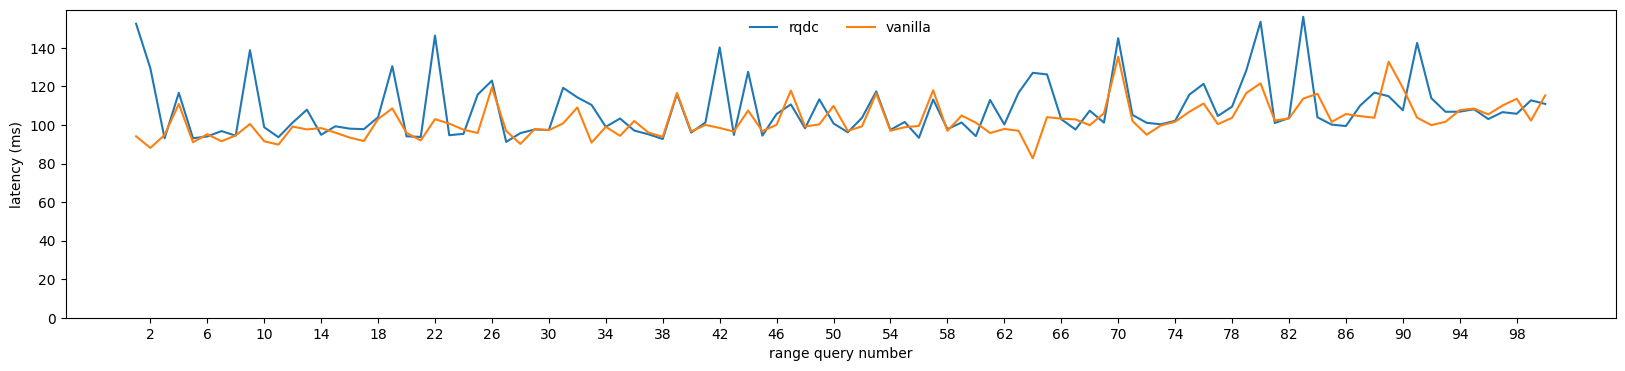

In [147]:
fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(rqdc_df.index, rqdc_df['totalTime']/(1000*1000), label="rqdc")
ax.plot(vanilla_df.index, vanilla_df['totalTime']/(1000*1000), label="vanilla")

ax.set_ylim(bottom=0)

ax.legend(loc="center", ncol=4, bbox_to_anchor=(0.5, 0.94), frameon=False)

ax.set_ylabel('latency (ms)')
ax.set_xlabel('range query number')

xlabel = [x+1 for x in range(1, 100, 4)]
ax.set_xticks(range(1, 100, 4))
ax.set_xticklabels(xlabel)

plt.show()

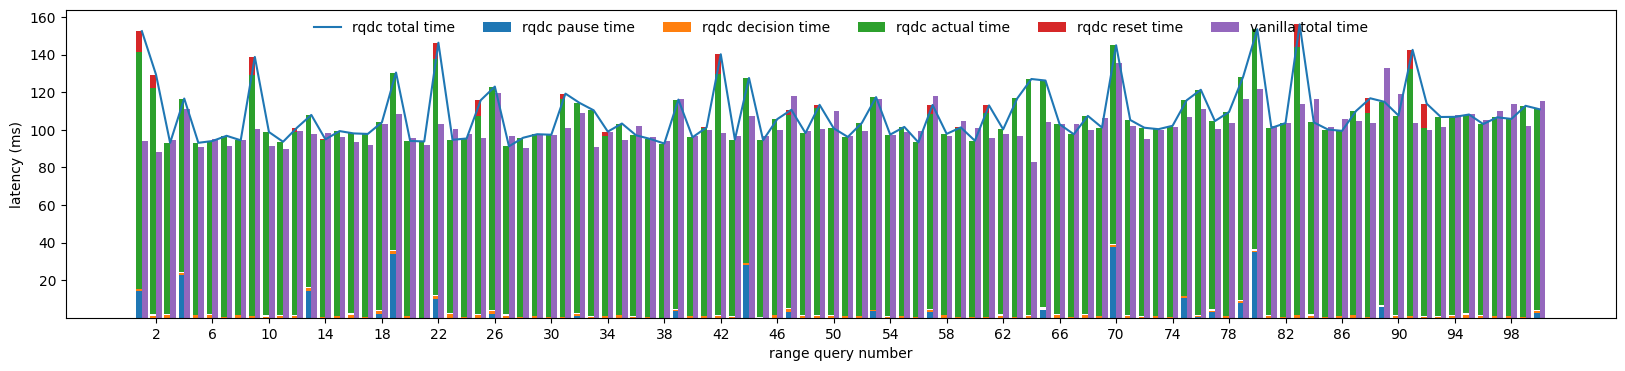

In [153]:
import matplotlib.pyplot as plt
import numpy as np

# Increased bar width for better visibility
width = 0.4  # Increase this width for thicker bars

# Index setup, ensuring enough space between groups
index = np.arange(len(rqdc_df))  # Converting index to a numeric array if not already

fig, ax = plt.subplots(figsize=(20, 4))

offset = width / 2  # Adjust this offset to align with the increased width

# Stacked bars
ax.bar(index - 0.2, rqdc_df["pauseTime"]/(1000*1000), width=width, label="rqdc pause time")
ax.bar(index - 0.2, rqdc_df["decisionMakingTime"]/(1000*1000), width=width, bottom=rqdc_df["pauseTime"]/(1000*1000), label="rqdc decision time")
ax.bar(index - 0.2, rqdc_df["actualTime"]/(1000*1000), width=width, bottom=rqdc_df["refreshTime"]/(1000*1000), label="rqdc actual time")
ax.bar(index - 0.2, rqdc_df["resetTime"]/(1000*1000), width=width, bottom=rqdc_df["actualTime"]/(1000*1000) + rqdc_df["refreshTime"]/(1000*1000), label="rqdc reset time")

ax.bar(index + 0.2, vanilla_df["totalTime"]/(1000*1000), width=width, label="vanilla total time")

ax.plot(rqdc_df.index, rqdc_df['totalTime']/(1000*1000), label="rqdc total time")

ax.legend(loc="center", ncol=6, bbox_to_anchor=(0.5, 0.94), frameon=False)

ax.set_ylabel('latency (ms)')
ax.set_xlabel('range query number')

xlabel = [x+1 for x in range(1, 100, 4)]
ax.set_xticks(range(1, 100, 4))
ax.set_xticklabels(xlabel)

plt.show()


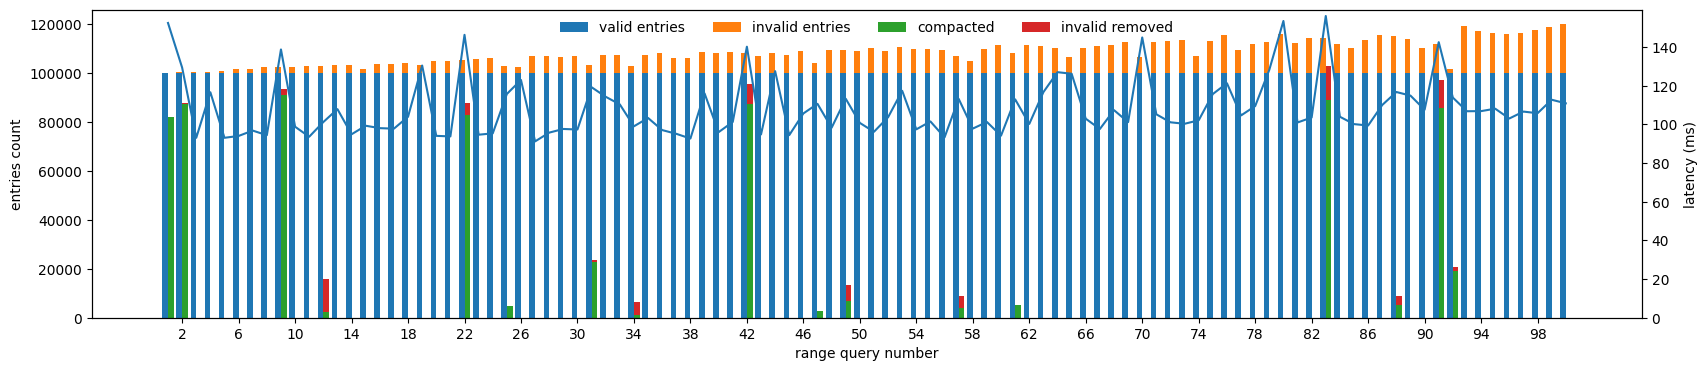

In [154]:
import matplotlib.pyplot as plt
import numpy as np

width = 0.4  # Increase this width for thicker bars

index = np.arange(len(rqdc_df))  # Converting index to a numeric array if not already

fig, ax = plt.subplots(figsize=(20, 4))

ax2 = ax.twinx()

offset = width / 2  # Adjust this offset to align with the increased width

ax.bar(index - 0.2, rqdc_df["idealEntriesCount"], width=width, label="valid entries")
ax.bar(index - 0.2, rqdc_df["invalidEntriesCount"], width=width, label="invalid entries", bottom=rqdc_df["idealEntriesCount"])

ax.bar(index + 0.2, rqdc_df["entriesCompacted"], width=width, label="compacted")
ax.bar(index + 0.2, rqdc_df["ToCompactAccurate"]-rqdc_df["entriesCompacted"], width=width, label="invalid removed", bottom=rqdc_df["entriesCompacted"])

ax2.plot(rqdc_df.index, rqdc_df['totalTime']/(1000*1000), label="rqdc")

ax.legend(loc="center", ncol=4, bbox_to_anchor=(0.5, 0.94), frameon=False)

ax.set_ylabel('entries count')
ax.set_xlabel('range query number')
ax2.set_ylabel('latency (ms)')

ax2.set_ylim(bottom=0)

xlabel = [x+1 for x in range(1, 100, 4)]
ax.set_xticks(range(1, 100, 4))
ax.set_xticklabels(xlabel)

plt.show()


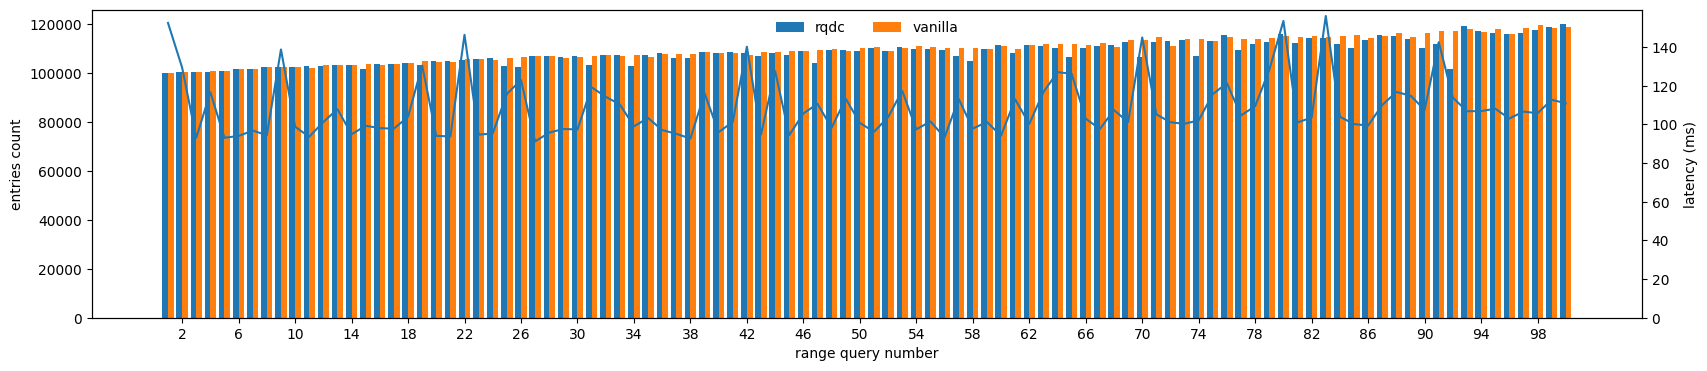

In [155]:
import matplotlib.pyplot as plt
import numpy as np

width = 0.4  # Increase this width for thicker bars

index = np.arange(len(rqdc_df))

fig, ax = plt.subplots(figsize=(20, 4))

ax2 = ax.twinx()

offset = width / 2  # Adjust this offset to align with the increased width

ax.bar(index - 0.2, rqdc_df["entriesCount"], width=width, label="rqdc")

ax.bar(index + 0.2, vanilla_df["entriesCount"], width=width, label="vanilla")

ax2.plot(rqdc_df.index, rqdc_df['totalTime']/(1000*1000), label="rqdc")
ax.legend(loc="center", ncol=4, bbox_to_anchor=(0.5, 0.94), frameon=False)

ax.set_ylabel('entries count')
ax.set_xlabel('range query number')
ax2.set_ylabel('latency (ms)')

ax2.set_ylim(bottom=0)

xlabel = [x+1 for x in range(1, 100, 4)]
ax.set_xticks(range(1, 100, 4))
ax.set_xticklabels(xlabel)

plt.show()
